In [8]:
%env GWDATAFIND_SERVER=https://datafind.igwn.org

env: GWDATAFIND_SERVER=https://datafind.igwn.org


In [2]:
import configargparse
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
torch.backends.cudnn.benchmark=True
torch.autograd.set_detect_anomaly(True)
import numpy as np
import glob
from tqdm import tqdm

# Import Pyxel to get the size of the maps
from GWpyxel.pyxel import Pyxel
from GWpyxel.const import PATH_TO_PYXEL

pyxel = Pyxel()

In [51]:
##############################################
###   CHECK THE ANOMALY SCORE WITH ALPHA   ###
##############################################

NfeatureMaps = 16
activation = nn.ELU()

# Feature extractor network
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=NfeatureMaps, kernel_size=3, 
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps),
            nn.ELU(True)
        )
        self.strided_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps, out_channels=NfeatureMaps*2, kernel_size=3,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*2),
            nn.ELU(True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*2, out_channels=NfeatureMaps*2, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*2),
            nn.ELU(True)
        )
        self.strided_conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*2, out_channels=NfeatureMaps*4, kernel_size=3,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*4),
            nn.ELU(True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*4, out_channels=NfeatureMaps*4, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*4),
            nn.ELU(True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*4, out_channels=NfeatureMaps*4, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*4),
            nn.ELU(True)
        )
        self.strided_conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*4, out_channels=NfeatureMaps*8, kernel_size=3,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*8),
            nn.ELU(True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*8, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.Dropout(p=0.5),
            nn.BatchNorm2d(NfeatureMaps*8),
            nn.ELU(True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*8, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.Dropout(p=0.5),
            nn.BatchNorm2d(NfeatureMaps*8),
            nn.ELU(True)
        )
        self.strided_conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*8, kernel_size=3,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*8),
            nn.ELU(True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*8, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.Dropout(p=0.5),
            nn.BatchNorm2d(NfeatureMaps*8),
            nn.ELU(True)
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*8, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.Dropout(p=0.5),
            nn.BatchNorm2d(NfeatureMaps*8),
            nn.ELU(True)
        )
        
        self.conv_trans1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*8, kernel_size=3, 
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*8),
            nn.ELU(True)
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*16, out_channels=NfeatureMaps*16, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*16),
            nn.ELU(True)
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*16, out_channels=NfeatureMaps*16, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*16),
            nn.ELU(True)
        )
        self.conv_trans2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=NfeatureMaps*16, out_channels=NfeatureMaps*4, kernel_size=3,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*4),
            nn.ELU(True)
        )
        self.conv11 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*8, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*8),
            nn.ELU(True)
        )
        self.conv12 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*8, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*8),
            nn.ELU(True)
        )
        self.conv_trans3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*2, kernel_size=3,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*2),
            nn.ELU(True)
        )
        self.conv13 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*4, out_channels=NfeatureMaps*4, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*4),
            nn.ELU(True)
        )
        self.conv_trans4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=NfeatureMaps*4, out_channels=NfeatureMaps, kernel_size=3,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps),
            nn.ELU(True)
        )
        self.conv14 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*2, out_channels=NfeatureMaps*2, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*2),
            nn.ELU(True)
        )
        
        self.conv_trans_inter1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=NfeatureMaps*16, out_channels=NfeatureMaps*2, kernel_size=3,
                stride=8, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*2),
            nn.ELU(True)
        )
        self.conv_trans_inter2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=NfeatureMaps*8, out_channels=NfeatureMaps*2, kernel_size=3,
                stride=4, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps*2),
            nn.ELU(True)
        )
        
        self.conv15 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps*2, out_channels=NfeatureMaps, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(NfeatureMaps),
            nn.ELU(True)
        )
        self.conv16 = nn.Sequential(
            nn.Conv2d(
                in_channels=NfeatureMaps, out_channels=1, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.ELU(True)
        )

    def forward(self, x):
        
        # Downscaling network
        # First Layer
        x1 = self.conv1(x)
        x2 = self.strided_conv1(x1)
        # Second Layer
        x3 = self.conv2(x2)
        x4 = activation(x3 + x2)
        x5 = self.strided_conv2(x4)
        # Third Layer
        x6 = self.conv3(x5)
        x7 = self.conv4(x6)
        x8 = activation(x7 + x5)
        x9 = self.strided_conv3(x8)
        # Fourth Layer
        x10 = self.conv5(x9)
        x11 = self.conv6(x10)
        x12 = activation(x11 + x9)
        x13 = self.strided_conv4(x12)
        # Fifth Layer
        x14 = self.conv7(x13)
        x15 = self.conv8(x14)
        x16 = activation(x15 + x13)
        
        del x15,x14,x13,x11,x10,x9,x7,x6,x5,x3,x2
        
        # Upscaling network
        # First Layer
        x17 = self.conv_trans1(x16)
        x18 = torch.cat( (x17,x12), 1)
        x19 = self.conv9(x18)
        x20 = self.conv10(x19)
        x21 = activation(x20 + x18)
        # Second Layer
        m = nn.ZeroPad2d((0,0,1,0))
        x22 = self.conv_trans2(x21)
        x22 = m(x22)
        x23 = torch.cat( (x22,x8), 1)
        x24 = self.conv11(x23)
        x25 = self.conv12(x24)
        x26 = activation(x25 + x23)
        # Third Layer
        x27 = self.conv_trans3(x26)
        x28 = torch.cat( (x27,x4), 1)
        x29 = self.conv13(x28)
        x30 = activation(x29 + x28)
        # Fourth Layer
        x31 = self.conv_trans4(x30)
        x31 = m(x31)
        x32 = torch.cat( (x31,x1), 1)
        x33 = self.conv14(x32)
        x34 = activation(x33 + x32)
        # Intermediate transposed conv
        #x1_inter = self.conv_trans_inter1(x21)
        #x2_inter = self.conv_trans_inter2(x26)
        # Putting everything together
        #x2_inter = m(x2_inter)
        #m = nn.ZeroPad2d((0,0,3,2))
        #x1_inter = m(x1_inter)
        #x35 = torch.cat( (x34, x1_inter, x2_inter), 1)
        x36 = self.conv15(x34)
        x37 = self.conv16(x36)
        
        return x37
    


In [47]:
pyxel = Pyxel()

pyxel.fetch_data('H1',1371668235,source='LIGO',cache=True)
pyxel.fetch_data('L1',1371668235,source='LIGO',cache=True)


duration = 50
f0 = 50
f1 = 950
f_ev = 'linear'
hrss = 7e-22

pyxel.inject_waveform(f'chirp~{duration}~{f0}~{f1}~{f_ev}~0.1', delay=200.5,  hrss=hrss)


pyxel.prewhitening()
pyxel.compute_coherence(pyxel.data.H1.value,pyxel.data.L1.value)
pyxel.postwhitening()
pyxel.name ='test'
pyxel.save_plot_albus()

In [52]:
# Load the trained network
alpha = FeatureExtractor()
alpha.load_state_dict(torch.load(f'{PATH_TO_PYXEL}/MLA/O4a/state_alpha.pth', map_location=torch.device('cpu')))
alpha.eval()

# Load the png saved
temp = Image.open('test.png')
torch_tensor = TF.to_tensor(temp)
torch_final = torch_tensor[:3,:,:].permute(0,2,1)
torch_final = torch_final.unsqueeze(0)
temp.close()

# Evaluate the anomaly score
output = alpha(torch_final)

In [53]:
tfmap = output[0][0].detach().numpy()

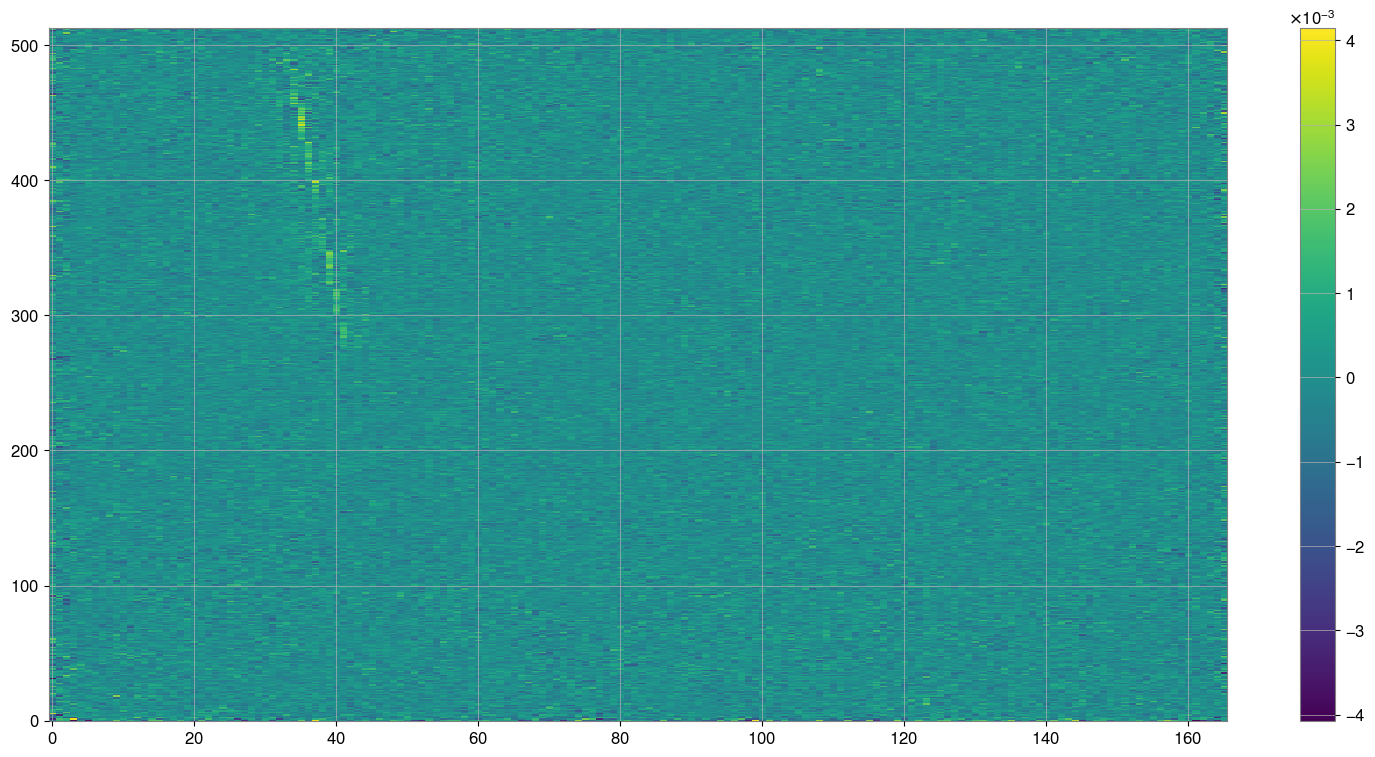

In [54]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(19,9))
plt.imshow(tfmap.T, aspect='auto', origin='lower', interpolation='None')
plt.colorbar()
plt.show();